In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "TALE"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn007791,MAEGFEPYHVPQQSRRDKLRVGGCVDNLQGCAGLLPAYDPSLIGPD...,507,1
1,Achn021251,MDDEAYGRLHTTADFSDNRPPPSEHLSLPVSHYPFASPPAFCDRSL...,307,1
2,Achn025901,MVSQDSPPNSASSILHQFIISDSISGQTQFENQHFEAYRNELRLIS...,430,1
3,Achn032201,MHISKEGCSSIGYGEAEELGPFFPQKGKPELKFNNHTWNKAANLLF...,294,1
4,Achn049161,MQIVVSSFDVVAGHGAAKPYTTLALKTISRHFRSLHDAISSQIRVT...,319,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1490,0.000000,0.000000,0.000000,0.000000,0.000000,0.003086,0.009259,0.009259,0.000000,0.006173,...,0.000000,0.003086,0.000000,0.003086,0.003086,0.000000,0.003086,0.000000,0.0,0.000000
1363,0.018072,0.000000,0.001506,0.001506,0.001506,0.006024,0.001506,0.003012,0.004518,0.006024,...,0.000000,0.003012,0.000000,0.001506,0.003012,0.003012,0.003012,0.000000,0.0,0.000000
890,0.000000,0.003257,0.000000,0.003257,0.003257,0.006515,0.003257,0.000000,0.003257,0.000000,...,0.000000,0.003257,0.003257,0.000000,0.003257,0.000000,0.003257,0.000000,0.0,0.000000
8405,0.009259,0.000000,0.000000,0.006173,0.003086,0.006173,0.000000,0.003086,0.003086,0.003086,...,0.009259,0.003086,0.003086,0.000000,0.006173,0.000000,0.000000,0.000000,0.0,0.003086
7432,0.000000,0.000000,0.002625,0.000000,0.000000,0.002625,0.000000,0.000000,0.000000,0.007874,...,0.002625,0.005249,0.000000,0.007874,0.000000,0.000000,0.000000,0.002625,0.0,0.005249


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7069, 441)
X_test: (1768, 441)
y_train: (7069,)
y_test: (1768,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 41s 474ms/step - accuracy: 0.4375 - loss: 0.6934

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6303 - loss: 0.6870   

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7261 - loss: 0.6341

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7573 - loss: 0.5914 - val_accuracy: 0.9880 - val_loss: 0.0451


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0912

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0387

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0351

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0341 - val_accuracy: 0.9908 - val_loss: 0.0338


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0067

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0179

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0215

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0222

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0221

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0221 - val_accuracy: 0.9922 - val_loss: 0.0323


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0047

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0465 

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0357

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0301

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0298 - val_accuracy: 0.9936 - val_loss: 0.0278


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0436

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0087

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0068

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0076 - val_accuracy: 0.9887 - val_loss: 0.0413


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0166

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0091

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0094

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0095 - val_accuracy: 0.9943 - val_loss: 0.0251


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0107

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0108

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0102

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0102 - val_accuracy: 0.9922 - val_loss: 0.0308


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0020

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0055

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0070

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0087

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0091 - val_accuracy: 0.9936 - val_loss: 0.0306


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0028

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0031

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0043

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0053 - val_accuracy: 0.9936 - val_loss: 0.0290


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0028

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0050

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0066

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0064 - val_accuracy: 0.9936 - val_loss: 0.0266


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 5.5685e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0050    

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0064

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0066 - val_accuracy: 0.9936 - val_loss: 0.0291


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5683e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0046    

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0048

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9866 - val_loss: 0.0493


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0032

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0072

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0060

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0054 - val_accuracy: 0.9929 - val_loss: 0.0337


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0050

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0109

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0144 - val_accuracy: 0.9929 - val_loss: 0.0283


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0048

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0048

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0053 - val_accuracy: 0.9915 - val_loss: 0.0341


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.9231e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0043    

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0037

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 0.9943 - val_loss: 0.0247



[Train Accuracy: 99.88% - Test Accuracy: 99.49%]


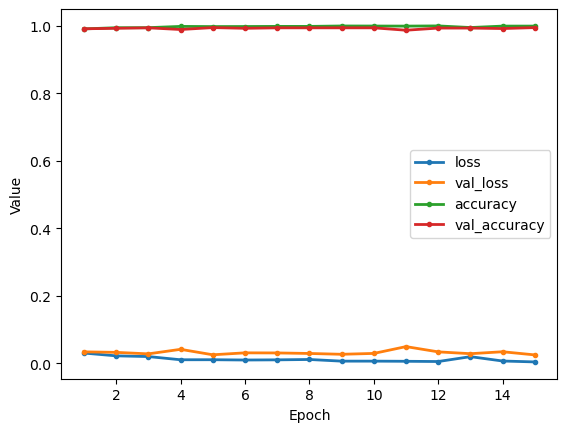

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1490,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1363,0.004525,0.0,0.0,0.0,0.001508,0.003017,0.001508,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
890,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8405,0.003096,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.003096,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7432,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.002632,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7069, 8874)
X_test: (1768, 8874)
y_train: (7069,)
y_test: (1768,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,272,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,265 (8.83 MB)

 Trainable params: 2,315,265 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 42s 485ms/step - accuracy: 0.5781 - loss: 0.6931

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6125 - loss: 0.6927   

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6715 - loss: 0.6909

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7213 - loss: 0.6863

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7545 - loss: 0.6782

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7800 - loss: 0.6647

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8004 - loss: 0.6450

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8187 - loss: 0.6185

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8320 - loss: 0.5937

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8433 - loss: 0.5695

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8530 - loss: 0.5467

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8603 - loss: 0.5281 - val_accuracy: 0.9972 - val_loss: 0.0114


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9844 - loss: 0.0130

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9932 - loss: 0.0092 

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9952 - loss: 0.0073

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9962 - loss: 0.0075

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0077

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9969 - loss: 0.0082

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0083

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0082

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0080

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0078

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0076

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9979 - loss: 0.0076 - val_accuracy: 0.9979 - val_loss: 0.0098


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 9.7191e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9960 - loss: 0.0177     

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9962 - loss: 0.0182

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9968 - loss: 0.0160

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0141

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0128

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0116

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0107

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0101

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0095

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0089

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9984 - loss: 0.0086 - val_accuracy: 0.9979 - val_loss: 0.0101


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 7.0688e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0360e-04 

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0717e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1661e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1806e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2839e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0011    

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0014

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0015

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0018

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0020

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9979 - val_loss: 0.0104


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.1323e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7694e-04 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9766e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8495e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6863e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5674e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 9.1590e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0011    

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0015

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0017

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0018

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9979 - val_loss: 0.0121


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.4238e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8002e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6753e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4545e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2622e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1028e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9744e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0802e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 6.6888e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 7.8633e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 8.6719e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 9.7757e-04 - val_accuracy: 0.9979 - val_loss: 0.0102


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.0912e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0035e-04 

18/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8995e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2733e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9999 - loss: 7.6406e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9999 - loss: 0.0011    

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9997 - loss: 0.0017

48/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9997 - loss: 0.0020

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0023

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0024

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0024

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0024

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9979 - val_loss: 0.0104


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.5153e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6053e-04 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5192e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4407e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3769e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3178e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2640e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2172e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1799e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3652e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1936e-04 - val_accuracy: 0.9950 - val_loss: 0.0251


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.4385e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010     

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0010

17/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.7005e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.3069e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 8.9059e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.7514e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.3003e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.9440e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.8091e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.5502e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.1301e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.9748e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.2871e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9999 - loss: 7.4294e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9999 - loss: 7.4711e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9999 - loss: 7.4722e-04 - val_accuracy: 0.9979 - val_loss: 0.0118


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.8536e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7544e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6940e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6509e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7297e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7260e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5934e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5382e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 1.1408e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 1.2627e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 1.3349e-04 - val_accuracy: 0.9979 - val_loss: 0.0137


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.7500e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1290e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9182e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9889e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9755e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9206e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8500e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7815e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7154e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8339e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.3801e-05 - val_accuracy: 0.9979 - val_loss: 0.0138


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.7728e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5359e-05 

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3143e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3149e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2390e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1759e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1095e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0457e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9057e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4196e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.9859e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.8970e-05 - val_accuracy: 0.9979 - val_loss: 0.0139



[Train Accuracy: 100.00% - Test Accuracy: 99.89%]


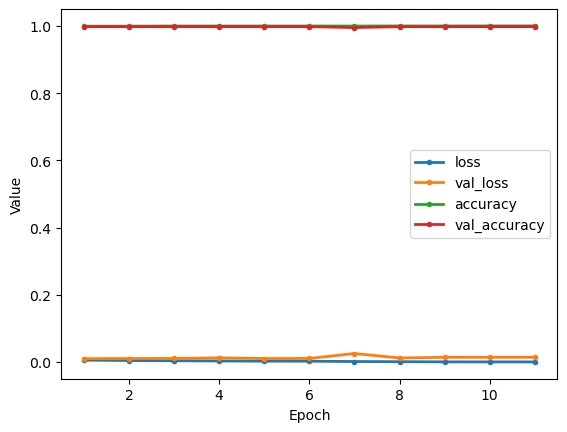

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1490,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1363,0.001511,0.0,0.0,0.0,0.0,0.0,0.001511,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
890,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8405,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7432,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,470,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,511,361 (146.91 MB)

 Trainable params: 38,511,361 (146.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1:03 726ms/step - accuracy: 0.6562 - loss: 0.6931

 2/89 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.6445 - loss: 0.6928  

 3/89 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.6293 - loss: 0.6927

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.6117 - loss: 0.6928

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.6012 - loss: 0.6927

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.5921 - loss: 0.6926

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.5850 - loss: 0.6925

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.5776 - loss: 0.6924

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5722 - loss: 0.6923

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.5675 - loss: 0.6922 

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5644 - loss: 0.6920

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.5612 - loss: 0.6918

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5577 - loss: 0.6916

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.5549 - loss: 0.6914

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5534 - loss: 0.6912

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.5527 - loss: 0.6909

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.5526 - loss: 0.6906

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.5532 - loss: 0.6903

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.5543 - loss: 0.6899

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5558 - loss: 0.6895

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5576 - loss: 0.6890

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.5598 - loss: 0.6885

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.5625 - loss: 0.6880

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.5655 - loss: 0.6875

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5689 - loss: 0.6869

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5726 - loss: 0.6862

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5764 - loss: 0.6854

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.5803 - loss: 0.6846

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.5842 - loss: 0.6838

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.5880 - loss: 0.6829

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.5920 - loss: 0.6819

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5959 - loss: 0.6809

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5998 - loss: 0.6799

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.6037 - loss: 0.6787

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6076 - loss: 0.6775

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.6115 - loss: 0.6762

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.6154 - loss: 0.6749

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.6192 - loss: 0.6735

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6230 - loss: 0.6721

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6267 - loss: 0.6705

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6304 - loss: 0.6689

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6341 - loss: 0.6673

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.6376 - loss: 0.6655

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.6412 - loss: 0.6637

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.6446 - loss: 0.6618

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.6481 - loss: 0.6598

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.6514 - loss: 0.6578

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6547 - loss: 0.6557

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.6580 - loss: 0.6535

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.6611 - loss: 0.6513

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.6643 - loss: 0.6491

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6673 - loss: 0.6468

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6703 - loss: 0.6444

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6733 - loss: 0.6420

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6762 - loss: 0.6395

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6791 - loss: 0.6370

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6819 - loss: 0.6345

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6846 - loss: 0.6319

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6874 - loss: 0.6293

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6900 - loss: 0.6267

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6926 - loss: 0.6240

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6952 - loss: 0.6214

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.6977 - loss: 0.6187

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7002 - loss: 0.6159

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7026 - loss: 0.6132

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7050 - loss: 0.6105

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7074 - loss: 0.6078

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7097 - loss: 0.6050

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.7120 - loss: 0.6023

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.7142 - loss: 0.5995

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.7164 - loss: 0.5968

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.7186 - loss: 0.5940

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.7207 - loss: 0.5913

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7228 - loss: 0.5885

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7248 - loss: 0.5858

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7268 - loss: 0.5831

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7288 - loss: 0.5804

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7308 - loss: 0.5777

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7327 - loss: 0.5750

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7346 - loss: 0.5723

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7365 - loss: 0.5696

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7383 - loss: 0.5670

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7401 - loss: 0.5643

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7419 - loss: 0.5617

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7437 - loss: 0.5591

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7454 - loss: 0.5565

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7471 - loss: 0.5540

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7488 - loss: 0.5514

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7504 - loss: 0.5489

89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.7521 - loss: 0.5464 - val_accuracy: 0.9965 - val_loss: 0.0156


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 1.0000 - loss: 0.0029

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 0.0031

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9983 - loss: 0.0049

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9977 - loss: 0.0058

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9976 - loss: 0.0061

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9971 - loss: 0.0128

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9969 - loss: 0.0167

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9968 - loss: 0.0191

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9967 - loss: 0.0205

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9968 - loss: 0.0213

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9968 - loss: 0.0218

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9968 - loss: 0.0221

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9969 - loss: 0.0222 

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9970 - loss: 0.0221

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9970 - loss: 0.0220

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9971 - loss: 0.0218

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9972 - loss: 0.0216

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9972 - loss: 0.0214

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9973 - loss: 0.0211

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9973 - loss: 0.0209

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9974 - loss: 0.0206

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9974 - loss: 0.0203

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9975 - loss: 0.0201

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9975 - loss: 0.0198

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9976 - loss: 0.0195

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9976 - loss: 0.0193

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9977 - loss: 0.0190

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9977 - loss: 0.0188

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9978 - loss: 0.0185

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9978 - loss: 0.0183

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9978 - loss: 0.0180

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9979 - loss: 0.0178

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9979 - loss: 0.0176

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9980 - loss: 0.0174

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9980 - loss: 0.0172

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9980 - loss: 0.0170

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9980 - loss: 0.0168

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9981 - loss: 0.0166

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9981 - loss: 0.0164

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9981 - loss: 0.0162

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9982 - loss: 0.0160

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9982 - loss: 0.0159

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9982 - loss: 0.0157

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9982 - loss: 0.0155

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9983 - loss: 0.0154

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9983 - loss: 0.0152

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9983 - loss: 0.0150

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9983 - loss: 0.0149

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9983 - loss: 0.0148

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9984 - loss: 0.0146

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9984 - loss: 0.0145

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9984 - loss: 0.0144

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9984 - loss: 0.0142

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9984 - loss: 0.0141

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9984 - loss: 0.0140

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9984 - loss: 0.0139

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9984 - loss: 0.0137

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0136

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0135

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0134

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0133

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0132

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0131

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0130

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9985 - loss: 0.0129

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9986 - loss: 0.0128

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9986 - loss: 0.0127

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9986 - loss: 0.0126

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9986 - loss: 0.0125

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9986 - loss: 0.0124

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9986 - loss: 0.0124

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9986 - loss: 0.0123

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9986 - loss: 0.0123

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9986 - loss: 0.0122

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9986 - loss: 0.0122

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9986 - loss: 0.0121

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9987 - loss: 0.0121

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9987 - loss: 0.0120

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9987 - loss: 0.0120

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9987 - loss: 0.0119

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9987 - loss: 0.0119

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9987 - loss: 0.0118

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9987 - loss: 0.0118

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9987 - loss: 0.0117

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9987 - loss: 0.0117

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9987 - loss: 0.0117

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9987 - loss: 0.0116

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9987 - loss: 0.0116

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9987 - loss: 0.0115

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.9987 - loss: 0.0115 - val_accuracy: 0.9965 - val_loss: 0.0136


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 1.0000 - loss: 0.0012

 2/89 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 0.0011

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0012

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 0.0011

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 0.0012

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 0.0012

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 0.0012

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 0.0012

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 0.0012

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 0.0012

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 0.0012

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 0.0012

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 0.0012

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 0.0012 

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 0.0012

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 0.0012

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 0.0012

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 0.0012

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 0.0012

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 0.0012

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 0.0012

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 0.0012

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 0.0012

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 0.0012

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 0.0015

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 0.0017

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9999 - loss: 0.0020

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9999 - loss: 0.0022

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9999 - loss: 0.0023

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9999 - loss: 0.0025

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9999 - loss: 0.0026

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9999 - loss: 0.0028

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9999 - loss: 0.0029

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9998 - loss: 0.0030

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9998 - loss: 0.0031

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9998 - loss: 0.0032

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9998 - loss: 0.0033

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9998 - loss: 0.0033

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9998 - loss: 0.0034

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9998 - loss: 0.0034

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9998 - loss: 0.0035

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0035

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0036

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0036

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0036

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0037

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0037

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0037

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 0.0037

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 0.0037

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 0.0038

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 0.0038

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9998 - loss: 0.0039

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9998 - loss: 0.0039

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9997 - loss: 0.0040

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9997 - loss: 0.0040

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9997 - loss: 0.0041

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0041

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0041

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0042

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0042

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0042

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0043

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0043

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9997 - loss: 0.0043

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9997 - loss: 0.0044

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9997 - loss: 0.0044

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9997 - loss: 0.0044

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9997 - loss: 0.0044

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9997 - loss: 0.0045

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9997 - loss: 0.0045

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9997 - loss: 0.0045

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9997 - loss: 0.0045

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9997 - loss: 0.0045

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0045

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0045

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0046

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0046

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0046

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9996 - loss: 0.0046

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0046

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9996 - loss: 0.0046

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0046

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9996 - loss: 0.0046

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9996 - loss: 0.0046

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9996 - loss: 0.0046

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9996 - loss: 0.0046

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9996 - loss: 0.0046

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9996 - loss: 0.0046

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9996 - loss: 0.0046 - val_accuracy: 0.9972 - val_loss: 0.0133


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 1.0000 - loss: 5.6856e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 5.1273e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.9983 - loss: 0.0208    

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9977 - loss: 0.0272

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9976 - loss: 0.0291

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9975 - loss: 0.0294

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9976 - loss: 0.0290

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9976 - loss: 0.0283

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9977 - loss: 0.0275

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9978 - loss: 0.0266

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9978 - loss: 0.0258 

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9979 - loss: 0.0249

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9980 - loss: 0.0241

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9980 - loss: 0.0234

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9981 - loss: 0.0227

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9982 - loss: 0.0220

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9982 - loss: 0.0214

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9983 - loss: 0.0208

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9983 - loss: 0.0202

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9984 - loss: 0.0197

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9984 - loss: 0.0192

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9984 - loss: 0.0187

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9985 - loss: 0.0183

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9985 - loss: 0.0179

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9986 - loss: 0.0175

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9986 - loss: 0.0171

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9986 - loss: 0.0167

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9986 - loss: 0.0164

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9987 - loss: 0.0161

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9987 - loss: 0.0157

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9987 - loss: 0.0154

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9988 - loss: 0.0152

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9988 - loss: 0.0149

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9988 - loss: 0.0146

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9988 - loss: 0.0144

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9988 - loss: 0.0141

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9989 - loss: 0.0139

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9989 - loss: 0.0137

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9989 - loss: 0.0134

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9989 - loss: 0.0132

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9989 - loss: 0.0130

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9989 - loss: 0.0128

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9990 - loss: 0.0127

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9990 - loss: 0.0125

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9990 - loss: 0.0123

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9990 - loss: 0.0121

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9990 - loss: 0.0120

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9990 - loss: 0.0118

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0116

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0115

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0114

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0112

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0111

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0109

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0108

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9991 - loss: 0.0107

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9991 - loss: 0.0106

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9992 - loss: 0.0104

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9992 - loss: 0.0103

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9992 - loss: 0.0102

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9992 - loss: 0.0101

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9992 - loss: 0.0100

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9992 - loss: 0.0099

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9992 - loss: 0.0098

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9992 - loss: 0.0097

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0096

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0095

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0094

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9992 - loss: 0.0093

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9993 - loss: 0.0092

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9993 - loss: 0.0091

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9993 - loss: 0.0091

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0090

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0089

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0088

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0087

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0087

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0086

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0085

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9993 - loss: 0.0085

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9993 - loss: 0.0084

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9993 - loss: 0.0083

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9993 - loss: 0.0083

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0082

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0081

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0081

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0080

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0080

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9993 - loss: 0.0079

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9993 - loss: 0.0078 - val_accuracy: 0.9950 - val_loss: 0.0266


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 1.0000 - loss: 7.2212e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 8.4684e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 1.0000 - loss: 8.3575e-04 

 4/89 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 1.0000 - loss: 8.1664e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 1.0000 - loss: 7.8517e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 7.6400e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 1.0000 - loss: 8.1896e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 1.0000 - loss: 8.4564e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 1.0000 - loss: 8.5638e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 8.5865e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 8.5672e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 8.5060e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 8.4296e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 8.3388e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 8.2413e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 8.1379e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 8.0294e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 7.9193e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 7.8075e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 7.7004e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 7.5940e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 7.4923e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 7.3923e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.2949e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.2055e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.1200e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.0375e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 6.9583e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 6.8834e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 6.8109e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 6.7419e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 6.6750e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 6.6103e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 6.5484e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 6.4882e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 6.4290e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 6.3716e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 6.3161e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 6.2619e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 6.2091e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.1591e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.1098e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.0620e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.0169e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.9725e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.9291e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.8885e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.8486e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.8095e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.7710e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.7342e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.6985e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.6638e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.6299e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.5966e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.5638e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.5317e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.4999e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.4686e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.4381e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.4081e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.3786e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.3495e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 5.3208e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.2928e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.2652e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.2381e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.2115e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.1852e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.1593e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.1338e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.1092e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.0850e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.0612e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.2359e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 5.4033e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 5.5638e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 5.7176e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 5.8649e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 6.0060e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.1413e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.2711e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.3956e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.5154e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.6304e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.7408e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.8468e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.9485e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 7.0473e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 7.1439e-04 - val_accuracy: 0.9958 - val_loss: 0.0195


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 1.0000 - loss: 2.4634e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3095e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 2.1469e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 2.2238e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.2594e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.2799e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.3028e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3839e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.4443e-04 

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.4792e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.4992e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.5149e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.5252e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.5303e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.5376e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.5409e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.5499e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.5585e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.5645e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.5672e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.5674e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.5660e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.5659e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.5646e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.5625e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.5615e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.5588e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.5547e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.5503e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.5489e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.5470e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.5443e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.5426e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.5401e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.5373e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5346e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5311e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5274e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.5229e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.5184e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.5140e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.5095e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.5046e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4998e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4972e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4943e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4911e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4875e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4836e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4797e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4756e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.4714e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.4670e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.4631e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.4591e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.4547e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.4511e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.4472e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.4439e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.4404e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.4372e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.4339e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.4307e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.4281e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.4254e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.4234e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.4212e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.4191e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.4170e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.4147e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.4123e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.4100e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 2.4075e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.4050e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 2.4025e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 2.4000e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.5409e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.6762e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.8063e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 2.9314e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.0517e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.1673e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.2786e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.3859e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.4893e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.5888e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.6848e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.7774e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.8675e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.9556e-04 - val_accuracy: 0.9965 - val_loss: 0.0193


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 28s 320ms/step - accuracy: 1.0000 - loss: 1.5931e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.6452e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9983 - loss: 0.0075    

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9977 - loss: 0.0098

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9976 - loss: 0.0105

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9975 - loss: 0.0106

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9976 - loss: 0.0104

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9976 - loss: 0.0102

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9977 - loss: 0.0099

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9978 - loss: 0.0096

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9978 - loss: 0.0093

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9979 - loss: 0.0090 

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9980 - loss: 0.0088

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9980 - loss: 0.0085

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9981 - loss: 0.0083

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9982 - loss: 0.0080

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9982 - loss: 0.0078

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9983 - loss: 0.0076

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.9983 - loss: 0.0074

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9984 - loss: 0.0073

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9984 - loss: 0.0071

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9984 - loss: 0.0069

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9985 - loss: 0.0068

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9985 - loss: 0.0066

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9986 - loss: 0.0065

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9986 - loss: 0.0063

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9986 - loss: 0.0062

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9986 - loss: 0.0061

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9987 - loss: 0.0060

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9987 - loss: 0.0059

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9987 - loss: 0.0058

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9988 - loss: 0.0057

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9988 - loss: 0.0056

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9988 - loss: 0.0055

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9988 - loss: 0.0054

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9988 - loss: 0.0053

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9989 - loss: 0.0052

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9989 - loss: 0.0051

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9989 - loss: 0.0050

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9989 - loss: 0.0050

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9989 - loss: 0.0049

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9989 - loss: 0.0048

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9990 - loss: 0.0048

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9990 - loss: 0.0047

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9990 - loss: 0.0046

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9990 - loss: 0.0046

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9990 - loss: 0.0045

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9990 - loss: 0.0044

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9991 - loss: 0.0044

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9991 - loss: 0.0043

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.0043

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.0042

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.0042

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.0041

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.0041

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.0040

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9991 - loss: 0.0040

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9992 - loss: 0.0040

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9992 - loss: 0.0039

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9992 - loss: 0.0039

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9992 - loss: 0.0038

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9992 - loss: 0.0038

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9992 - loss: 0.0038

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9992 - loss: 0.0037

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9992 - loss: 0.0037

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9992 - loss: 0.0037

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9992 - loss: 0.0036

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9992 - loss: 0.0036

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9992 - loss: 0.0035

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9993 - loss: 0.0035

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9993 - loss: 0.0035

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9993 - loss: 0.0035

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9993 - loss: 0.0034

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9993 - loss: 0.0034

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9993 - loss: 0.0034

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9993 - loss: 0.0033

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9993 - loss: 0.0033

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9993 - loss: 0.0033

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9993 - loss: 0.0033

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9993 - loss: 0.0032

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9993 - loss: 0.0032

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0032

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0032

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9993 - loss: 0.0031

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9994 - loss: 0.0031

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9994 - loss: 0.0031

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9994 - loss: 0.0031

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9994 - loss: 0.0030

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9994 - loss: 0.0030

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9965 - val_loss: 0.0182


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 1.0000 - loss: 1.1812e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 1.0000 - loss: 1.2746e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.3339e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 1.3432e-04 

 5/89 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 1.3602e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 1.0000 - loss: 1.3688e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 1.3653e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 1.3587e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.3530e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 1.3463e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.3412e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.3360e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.3344e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 1.3379e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.3417e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.3426e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3421e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3420e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3414e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3415e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3409e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.3389e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3377e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.3365e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.3363e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3362e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3357e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3361e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.3370e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3374e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.3378e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.3377e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.3373e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3366e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3360e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3358e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.3709e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.4035e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.4336e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.4615e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4870e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5107e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5325e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5532e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5723e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5898e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.6059e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.6211e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6352e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6483e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6605e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6718e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6822e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6919e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.7007e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.7090e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7166e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7239e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7306e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7373e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7433e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7490e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7542e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.7590e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.7636e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.7678e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7715e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7749e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.7780e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.7807e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.7831e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.7854e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.7875e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.7893e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.7909e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.7925e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.7939e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7951e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7961e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7970e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.7976e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.7980e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.7983e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.7986e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.7989e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.7990e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.7992e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.7991e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.7992e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.7993e-04 - val_accuracy: 0.9965 - val_loss: 0.0192


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - accuracy: 1.0000 - loss: 6.9580e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 8.9861e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.9312e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.2681e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3615e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.3817e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.3573e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3298e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.2949e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2545e-04 

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2105e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.1638e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.1196e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.0799e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.0423e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.0060e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.9715e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.9397e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.9092e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.8794e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.8521e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.8259e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.8014e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.7778e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 1.7548e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.7324e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.7112e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6916e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6742e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6572e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.6409e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.6254e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.6105e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5960e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.5819e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.5683e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.5549e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.5419e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.5290e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5166e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5045e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4926e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4814e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4707e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4602e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4500e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4400e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4302e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4206e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4112e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.4021e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3937e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3855e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.3774e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.3695e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.3618e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3542e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3468e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3395e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3324e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3255e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3187e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3122e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.3057e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2995e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.2934e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2873e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.2813e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2755e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2698e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2641e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.2586e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.2532e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.2479e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.2426e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.2374e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.2323e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.2273e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.2224e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.2175e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.2128e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.2081e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.2034e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1990e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1945e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1902e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1860e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1818e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1776e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.1736e-04 - val_accuracy: 0.9965 - val_loss: 0.0186


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 27s 318ms/step - accuracy: 1.0000 - loss: 5.1150e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 5.0370e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 5.2778e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 5.4074e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 5.6383e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 5.7907e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 5.8621e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.9372e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 6.0365e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 6.1488e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.2420e-05 

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 6.3222e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.3704e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.4435e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.5087e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.5568e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.5909e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.6116e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.6294e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.6380e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.6462e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.6484e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.6465e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 6.6408e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 6.6327e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.6215e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.6076e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.5916e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 6.5772e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 6.5649e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 6.5508e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 6.5383e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.5237e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.5094e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.4938e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.4772e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.4625e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 6.4479e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 6.4335e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 6.4183e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.4048e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.3904e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3754e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3600e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3443e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3550e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3652e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.3733e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.3808e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.3870e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.3916e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.3948e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.3977e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.4007e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.4024e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.4035e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4045e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4051e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4049e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4039e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4026e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4006e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.3983e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.3952e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3924e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3892e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3852e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3813e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3773e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3728e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3690e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3645e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3605e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3567e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3526e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3484e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3435e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3382e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3326e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 6.3270e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.3213e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.3162e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.3109e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.3054e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2998e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2940e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2879e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2820e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.2761e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 6.2704e-05 - val_accuracy: 0.9965 - val_loss: 0.0190


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 1.0000 - loss: 4.6117e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 4.1343e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 4.2333e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 4.5077e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 4.6096e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 4.6782e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 4.6932e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 4.8656e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 5.0309e-05 

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1616e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.2473e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.3257e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.3753e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.4027e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.4321e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 5.4450e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.4460e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.4427e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.4315e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.4227e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.4093e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.3946e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.3784e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.3752e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 5.3863e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 5.3958e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 5.3997e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.4041e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.4049e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.4030e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.3994e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.3964e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 5.3985e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 5.3990e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 5.3983e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 5.3959e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 5.3916e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.3855e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.3792e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.3717e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3636e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3545e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3460e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3383e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3296e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3204e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3112e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3016e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.2927e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.2843e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.2762e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.2684e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.2610e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.2538e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 5.2463e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 5.2389e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 5.2313e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.2233e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 5.2152e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 5.2079e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 5.2002e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 5.1933e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 5.1865e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 5.1874e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.1877e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.1879e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.1887e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.1894e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.1899e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 5.1899e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.1899e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 5.1897e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1890e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1879e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1864e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1845e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1826e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1804e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1780e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 5.1757e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1731e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1704e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1675e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 5.1651e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1624e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1597e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1569e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1538e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 5.1508e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 5.1478e-05 - val_accuracy: 0.9965 - val_loss: 0.0199


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 1.0000 - loss: 3.3071e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.9356e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 2.8416e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 3.2882e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 3.4889e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 3.6115e-05 

 7/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 3.6696e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 3.6940e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 3.6918e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 1.0000 - loss: 3.9674e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 4.1496e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 4.2812e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 1.0000 - loss: 4.3694e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 4.4287e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 1.0000 - loss: 4.4680e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 1.0000 - loss: 4.4933e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.5128e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.5221e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.6335e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.7276e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.8092e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 4.8750e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 4.9303e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 4.9754e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 5.0130e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 5.0445e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 5.0714e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 5.0918e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 5.1078e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 5.1179e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 5.1271e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1325e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1345e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1384e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1415e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1423e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1411e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1377e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.1329e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 5.1294e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.1248e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.1194e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.1128e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.1057e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.0975e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 5.0886e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.0792e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.0698e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0603e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0505e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0409e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0309e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0205e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 5.0103e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.9995e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.9884e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.9768e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.9655e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.9541e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 4.9425e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.9314e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.9204e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.9093e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.8981e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.8870e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.8758e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.8644e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.8533e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.8423e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.8311e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 4.8199e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.8089e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7980e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7872e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7763e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7654e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7545e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7434e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7328e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.7224e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.7120e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.7018e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6917e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6815e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6712e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6609e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6512e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6414e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.6319e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 4.6225e-05 - val_accuracy: 0.9965 - val_loss: 0.0211


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 1.0000 - loss: 2.3301e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 2.2845e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 2.2869e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 2.3013e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.3325e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.3355e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.3156e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.3381e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.3496e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.3895e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.4222e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.4533e-05 

13/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.4893e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5155e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.5350e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 2.5513e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.5615e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.5740e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.5840e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.5950e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.6042e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.6125e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.6179e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.6280e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.6385e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6474e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6540e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6592e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6645e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6693e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6728e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6747e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.6762e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6764e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6758e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6754e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6753e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6746e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6741e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6737e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.6726e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6713e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6697e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6702e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6705e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6700e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6690e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.6672e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.6651e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6655e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6657e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6654e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6645e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6652e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6661e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.6668e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6671e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6670e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6664e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6659e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6651e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6645e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6635e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.6622e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6610e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6595e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6581e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6567e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6549e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6530e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6510e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6491e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6474e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6457e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6507e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6554e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.6597e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.6637e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.6674e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.6710e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6745e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6778e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6809e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6838e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6863e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6893e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6921e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6952e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 2.6983e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.7013e-05 - val_accuracy: 0.9965 - val_loss: 0.0211



[Train Accuracy: 100.00% - Test Accuracy: 99.83%]


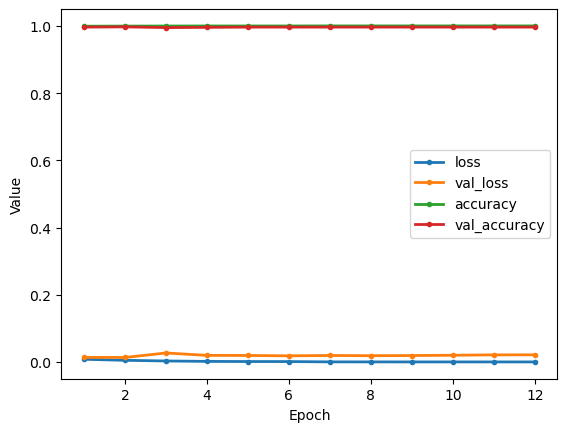

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step

 6/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

11/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

22/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

27/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

37/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

48/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

54/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step

 6/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

36/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

42/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

52/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/TALE/report_O4TP5WHR.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################